In [1]:
import mpramnist
from mpramnist.StarrSeq.dataset import StarrSeqDataset

from mpramnist.models import CNN_cls
from mpramnist.trainers import LitModel_StarrSeq

from mpramnist import transforms as t
from mpramnist import target_transforms as t_t

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data

import pytorch_lightning as L
from torch.nn import functional as F

In [2]:
import sklearn
from sklearn.metrics import (
    precision_score,
    recall_score,
    precision_recall_curve,
    auc,
    average_precision_score,
)
import matplotlib.pyplot as plt
def plot_pr_auc(
    model: nn.Module,
    loader: torch.utils.data.DataLoader,
    threshold: float = 0.5,
    figsize = (4, 3),
) -> None:
    """
    Plot Precision-Recall curve and compute PR-AUC metrics.
    
    Args:
        model: Trained PyTorch model
        loader: DataLoader with test/validation data
        threshold: Decision threshold for precision/recall calculation
        figsize: Size of the output figure
    """
    sigmoid = nn.Sigmoid()
    
    # Get predictions
    predictions = trainer.predict(model, dataloaders=loader)
    
    y_preds = torch.cat([pred["predicted"] for pred in predictions]).cpu()
    targets = torch.cat([pred["target"] for pred in predictions]).cpu()
    
    # Apply sigmoid and prepare numpy arrays
    y_scores = sigmoid(y_preds).numpy()
    y_pred = (y_scores >= threshold).astype(int)
    y_true = targets.numpy()
    
    # Calculate metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    avg_precision = average_precision_score(y_true, y_scores)
    
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall_vals, precision_vals)
    
    # Print metrics
    print(f"Precision (при пороге {threshold}): {precision:.2f}")
    print(f"Recall (при пороге {threshold}): {recall:.2f}")
    print(f"Average Precision Score: {avg_precision:.2f}")
    print(f"PR-AUC: {pr_auc:.2f}")
    
    # Plot curve
    plt.figure(figsize=figsize)
    plt.plot(
        recall_vals, 
        precision_vals, 
        label=f'PR Curve (AUC = {pr_auc:.2f})', 
        linewidth=2
    )
    plt.xlabel('Recall', fontsize=10)
    plt.ylabel('Precision', fontsize=10)
    plt.title('Precision-Recall Curve', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Tasks

In [3]:
tasks = ["RandomEnhancer",           # 0
          "GenomicPromoter",         # 1
          "CapturePromoter",         # 2
          
          "GenomicEnhancer",         # 3
          "AtacSeq",                 # 4
          
          "differentialExpression",  # 5

          "Binary"                   # 6
         ]

# Random Enhancer

In [ ]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])
task = "RandomEnhancer"
train_dataset = StarrSeqDataset(task = task, split = "train",transform = train_transform, root = "../data")

val_dataset = StarrSeqDataset(task = task, split = "val",transform = val_test_transform, root = "../data") 

test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform, root = "../data")

In [ ]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

In [ ]:
seq_len = len(train_dataset[0][0][0])
model = CNN_cls(seq_len = seq_len)

seq_model = LitModel_StarrSeq(model = model,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 5)

In [4]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [4]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


NameError: name 'seq_model' is not defined

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.69
Recall (при пороге 0.5): 0.04
PR-AUC (correct): 0.55
PR-AUC: 0.55


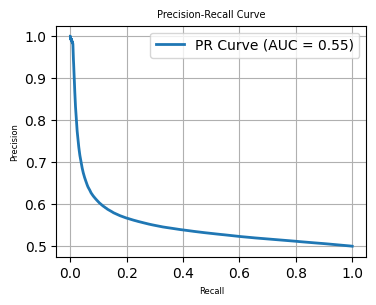

In [8]:
plot_pr_auc(seq_model, test_loader)

# Genomic promoter

In [4]:
BATCH_SIZE = 128
NUM_WORKERS = 103

In [5]:
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.ReverseComplement(0.5)
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

In [6]:
task = "genomicpromoter"
train_dataset = StarrSeqDataset(task = task, split = "train",transform = train_transform, root = "../data/")

val_dataset = StarrSeqDataset(task = task, split = "val",transform = val_test_transform, root = "../data/") 

**Please note:** the test file provided by the authors contains an error and cannot be used in your work. If you set `split = test`, the variable will automatically be switched to `val`.

In [7]:
test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform, root = "../data/")

/home/nios/5Term/mpramnist/StarrSeq/dataset.py:85: UserWarning: WARNING! The test dataset released by the authors of the study contains an error.You selected 'split = train', the system automatically changes it to 'val' for this operation.
  warnings.warn(


In [8]:
print(train_dataset)
print("===================")
print(val_dataset)

Dataset StarrSeqDataset of size 40996 (MpraDaraset)
    Number of datapoints: 40996
    Used split fold: train
Dataset StarrSeqDataset of size 7285 (MpraDaraset)
    Number of datapoints: 7285
    Used split fold: val


In [9]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [10]:
seq_len = len(train_dataset[0][0][0])

model = CNN_cls(seq_len = seq_len)

seq_model = LitModel_StarrSeq(model = model,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 1)

In [11]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    enable_model_summary=False
)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=1` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 0 | Val Acc: 0.8649279475212097 | Val AUROC: 0.9423571825027466 | Val AUPR: 0.9513117671012878 |
| Val Precision: 0.937685489654541 | Val Recall: 0.7815333604812622 | Val F1: 0.8525179624557495 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Precision (при пороге 0.5): 0.85
Recall (при пороге 0.5): 0.89
Average Precision Score: 0.93
PR-AUC: 0.95


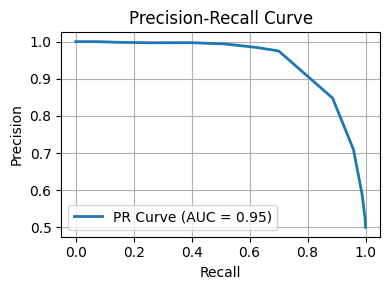

In [15]:
plot_pr_auc(seq_model, val_loader)

# Promoter capture

In [16]:
BATCH_SIZE = 512
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

In [8]:
task = "CapturePromoter"

train_dataset = StarrSeqDataset(task = task, split = "train",transform = train_transform, root = "../data/")

val_dataset = StarrSeqDataset(task = task, split = "val",transform = val_test_transform, root = "../data/") 

test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform, root = "../data/")

In [9]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 79732 (MpraDaraset)
    Number of datapoints: 79732
    Used split fold: train
Dataset StarrSeqDataset of size 13290 (MpraDaraset)
    Number of datapoints: 13290
    Used split fold: test


In [18]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [19]:
seq_len = len(train_dataset[0][0][0])
model = CNN_cls(seq_len = seq_len)

seq_model = LitModel_StarrSeq(model = model,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 5)

In [20]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nios/5Term/examples/lightning_logs/version_58/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | Simple_Classification_Net | 386 K  | train
1 | loss  | BCEWithLogitsLoss         | 0      | train
------------------------------------------------------------
386 K     Trainable params
0         Non-trainable params
386 K     Total params
1.547     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.50
Recall (при пороге 0.5): 1.00
PR-AUC (correct): 0.50
PR-AUC: 0.75


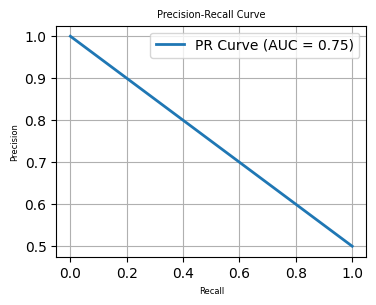

In [21]:
plot_pr_auc(seq_model, test_loader)

# Genome enhancer

In [22]:
BATCH_SIZE = 1024
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

In [10]:
task = "GenomicEnhancer"

train_dataset = StarrSeqDataset(task = task, split = "train",transform = train_transform, root = "../data/")

val_dataset = StarrSeqDataset(task = task, split = "val",transform = val_test_transform, root = "../data/")

test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform, root = "../data/")

In [11]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 323756 (MpraDaraset)
    Number of datapoints: 323756
    Used split fold: ['chr1', 'chr3', 'chr5', 'chr7', 'chr9', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Dataset StarrSeqDataset of size 99362 (MpraDaraset)
    Number of datapoints: 99362
    Used split fold: ['chr2', 'chr10', 'chr11']


In [24]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [25]:
seq_len = len(train_dataset[0][0][0])
model = CNN_cls(seq_len = seq_len)

seq_model = LitModel_StarrSeq(model = model,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 5)

In [26]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nios/5Term/examples/lightning_logs/version_58/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | Simple_Classification_Net | 540 K  | train
1 | loss  | BCEWithLogitsLoss         | 0      | train
------------------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.162     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.47
Recall (при пороге 0.5): 1.00
PR-AUC (correct): 0.47
PR-AUC: 0.73


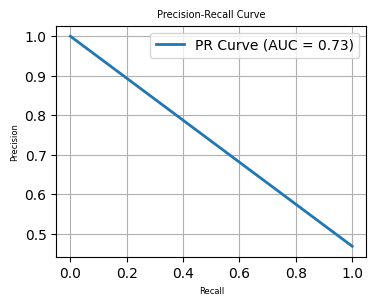

In [27]:
plot_pr_auc(seq_model, test_loader)

# ATACseq

In [28]:
BATCH_SIZE = 2048
NUM_WORKERS = 103
train_transform = t.Compose([
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

In [12]:
task = "atacseq"

train_dataset = StarrSeqDataset(task = task, split = "train",transform = train_transform, root = "../data/")

val_dataset = StarrSeqDataset(task = task, split = "val",transform = val_test_transform, root = "../data/")

test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform, root = "../data/")

In [13]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 2712578 (MpraDaraset)
    Number of datapoints: 2712578
    Used split fold: ['chr1', 'chr3', 'chr5', 'chr7', 'chr9', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Dataset StarrSeqDataset of size 912794 (MpraDaraset)
    Number of datapoints: 912794
    Used split fold: ['chr2', 'chr10', 'chr11']


In [30]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [31]:
seq_len = len(train_dataset[0][0][0])
model = CNN_cls(seq_len = seq_len)

seq_model = LitModel_StarrSeq(model = model,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-1, lr = 1e-2, print_each = 5)

In [32]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

/home/nios/miniconda3/envs/mpra/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/nios/5Term/examples/lightning_logs/version_58/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | Simple_Classification_Net | 540 K  | train
1 | loss  | BCEWithLogitsLoss         | 0      | train
------------------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.162     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Precision (при пороге 0.5): 0.51
Recall (при пороге 0.5): 1.00
PR-AUC (correct): 0.51
PR-AUC: 0.76


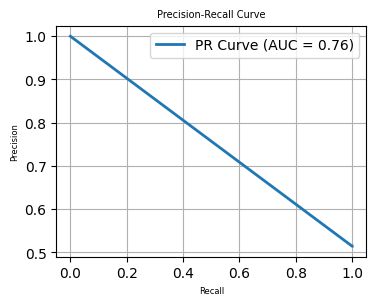

In [33]:
plot_pr_auc(seq_model, test_loader)

# Binary task

In [4]:
BATCH_SIZE = 1024
NUM_WORKERS = 103

train_transform = t.Compose([
    t.Seq2Tensor(),
    #t.ReverseComplement(0.5)
])
val_test_transform = t.Compose([
    t.Seq2Tensor()
])

In [5]:
binary_train = ["promoter_from_input", "enhancer_permutated", "enhancer_from_input"]
task = tasks[6]

train_dataset = StarrSeqDataset(task = task, binary_class = None, split = "train", transform = train_transform, root = "../data/")

val_dataset = StarrSeqDataset(task = task, split = "val", transform = val_test_transform, root = "../data/")

test_dataset = StarrSeqDataset(task = task, split = "test", transform = val_test_transform, root = "../data/")

using train
using val
using test


In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset StarrSeqDataset of size 2991302 (MpraDaraset)
    Number of datapoints: 2991302
    Used split fold: train
Dataset StarrSeqDataset of size 1252044 (MpraDaraset)
    Number of datapoints: 1252044
    Used split fold: test


In [7]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [8]:
len(train_dataset[0][0]["seq_enh"][0])

150

In [9]:
seq_len = len(train_dataset[0][0]["seq_enh"][0])

model = CNN_cls(seq_len = seq_len, is_binary = True, block_sizes=[16, 32, 64, 96, 126, 64], kernel_size=5)

seq_model = LitModel_StarrSeq(model = model, is_binary = True,
                           loss = torch.nn.BCEWithLogitsLoss(),
                           weight_decay = 1e-2, lr = 1e-2, print_each = 1)

In [10]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=1,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    enable_model_summary=False
)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)
`Trainer.fit` stopped: `max_epochs=1` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 0 | Val Acc: 0.7378690242767334 | Val AUROC: 0.8112067580223083 | Val AUPR: 0.8169608116149902 |
| Val Precision: 0.7565615773200989 | Val Recall: 0.7014400959014893 | Val F1: 0.7279588580131531 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…

Precision (при пороге 0.5): 0.62
Recall (при пороге 0.5): 0.90
Average Precision Score: 0.74
PR-AUC: 0.81


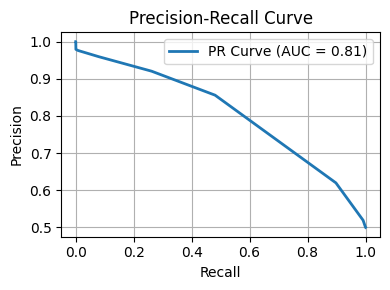

In [12]:
plot_pr_auc(seq_model, test_loader)